<h1>Import libraries<h1>

In [1]:
from Model.Random_Forest_Classifier_from_scratch import *
from Model.Random_Forest_Regressor_from_scratch import *
from Model.Random_Forest_optimization_pre_pruning import *
from Model.Random_Forest_optimization_post_pruning import *
from Metrics.Classification_metrics import *
from Metrics.Regression_metrics import *
from Plots.Prediction_plots import *
Plots_predictions = Prediction_plots()

<h1>Explanation of Random Forest<h1>

$\text{Random forest is an algorithm that can be used for both regression and classification problems.}$<p>
$\text{A random forest is a combination of multiple decision trees (ensembles), and prediction is the averaging of the results/voting of these trees.}$<p>
$\text{As a result, the forest should have a lower variance than a single tree.}$<p>
$\text{One of the methods used by Ensemble is } \textbf{Bagging.}$

<h3>Bagging<h3>

$\text{Bagging also known as Boostrap Aggregation, involves selecting a random sample (with return) from our dataset (Bootsrap).}$<p>
$\text{Each model/decision tree is trained independently, and the final result is based on a majority vote after the results from all models are combined (Aggregation).}$

<h2>Construction of Random Forest<h2>

$\text{Due to the fact that the random forest is built like decision tree, all of the operations were discussed in this notebook: }$ [Decision Tree Example](https://github.com/kvbiii/ML_Algorithms_from_scratch/blob/main/Decision_Tree/Decision_Tree_example.ipynb)<p>
$\text{This notebook will only present the scheme for the construction of random forest:}$<p>
$1. \text{ Determining T - the number of trees (in sklearn the parameter } n\_estimators \text{ is responsible for this).}$<p><br>
$2. \text{ Randomly draw with return N observations from the entire dataset containing N observations.}$<p>
$\text{This means that there will be some duplicates among the drawn samples.}$<p>
$\text{It is hard to determine how many different values our bootstrap subset will contain, but with } 100\% \text{ probability we can say that it will contain } \leq N \text{ unique observations.}$<p><br>
$3. \text{ Drawing without return a fixed number of variables (for example, the root of all) against which we will divide the nodes.}$<p><br>
$4. \text{ Building a tree based on the drawn set from point 2. and 3.}$<p><br>
$5. \text{ Checking whether the set number of trees T has been achieved.}$<p>
$\text{If not, return to step 2. and build a new tree.}$<p>
$\text{Otherwise, calculate the error and determine the result based on the combination of results from all models.}$

<h2>Basic properties of a random forest<h2>

$\text{- Diversity: each tree is different (different combination of variables and observations).}$<p>
$\text{- Immunity to the curse of dimensionality: a limited number of variables are taken into account.}$<p>
$\text{- Independence: the trees are independent of each other (you can take full advantage of the processor to build forests by building trees simultaneously).}$<p>
$\text{- Stability: the result is based on majority voting, which allows the results to be averaged (less error variance).}$

<h1>Preprocessing<h1>

<h2>Download data<h2>

In [2]:
data = pd.read_csv("Data/bank-balanced.csv")
X = data.drop("deposit", axis=1)
y = data["deposit"]

In [3]:
print("Number of observations in data: {}".format(len(data)))
data.head()

Number of observations in data: 11162


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


<h2>Check for null data<h2>

In [4]:
data.isnull().sum()/len(data)

age          0.0
job          0.0
marital      0.0
education    0.0
default      0.0
balance      0.0
housing      0.0
loan         0.0
contact      0.0
day          0.0
month        0.0
duration     0.0
campaign     0.0
pdays        0.0
previous     0.0
poutcome     0.0
deposit      0.0
dtype: float64

<h2>Convert object to numeric<h2>

$\text{For random forest we have to convert object/string features to numeric.}$<p>
$\text{For random forest, the best option would be to use OridinalEncoding instead of OneHotEncoding because of that algorithm's problem with the curse of dimensionality}$

In [5]:
list_of_object_features_classification = data.select_dtypes(include="object").columns.tolist()
list_of_numeric_features_classification = data.select_dtypes(exclude="object").columns.tolist()
encoder = OrdinalEncoder()
data[list_of_object_features_classification] = encoder.fit_transform(data[list_of_object_features_classification])

<h2>Divide our data into train and test sets<h2>

In [6]:
target_binary = "deposit"
X = data.drop(target_binary, axis=1)
y = data[[target_binary]]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=17, test_size=0.2)

$\text{The huge advantage of random forest compared to other popular algorithms is that there is no need to scale the data.}$

<h1>Modelling<h1>

$\text{To verify how well our algorithms are able to perform, a cross-validation will be used on the training set (in order to average the results obtained).}$<p>
$\text{Then we will check whether the algorithms will perform equally well (or even better) on the test data.}$

In [7]:
class Cross_Validation():
    def __init__(self, metric, algorithm_instance, cross_validation_instance):
        metrics = {"accuracy": [lambda y, y_pred: accuracy_score(y, y_pred), "preds"],
                    "roc_auc": [lambda y, y_pred: roc_auc_score(y, y_pred), "probs"],
                    "mse": [lambda y, y_pred: mean_squared_error(y, y_pred), "preds"],
                    "rmse": [lambda y, y_pred: mean_squared_error(y, y_pred)**0.5, "preds"],
                    "mae": [lambda y, y_pred: mean_absolute_error(y, y_pred), "preds"]}
        if metric not in metrics:
            raise ValueError('Unsupported metric: {}'.format(metric))
        self.eval_metric = metrics[metric][0]
        self.metric_type = metrics[metric][1]
        self.algorithm = algorithm_instance
        self.cv = cross_validation_instance
    
    def fit(self, X, y, verbose=False):
        X = self.check_X(X=X)
        y = self.check_y(y=y)
        self.train_scores, self.valid_scores = [], []
        for iter, (train_idx, valid_idx) in enumerate(self.cv.split(X, y)):
            X_train, X_valid = X[train_idx, :], X[valid_idx, :]
            y_train, y_valid = y[train_idx], y[valid_idx]
            self.algorithm.fit(X_train, y_train)
            if(self.metric_type == "preds"):
                y_train_pred = self.algorithm.predict(X_train)
                y_valid_pred = self.algorithm.predict(X_valid)
            else:
                y_train_pred = self.algorithm.predict_proba(X_train)[:, 1]
                y_valid_pred = self.algorithm.predict_proba(X_valid)[:, 1]
            self.train_scores.append(self.eval_metric(y_train, y_train_pred))
            self.valid_scores.append(self.eval_metric(y_valid, y_valid_pred))
            if(verbose == True):
                print("Iter {}: train scores: {}; valid scores: {}".format(iter, np.round(self.eval_metric(y_train, y_train_pred), 5), np.round(self.eval_metric(y_valid, y_valid_pred), 5)))
        return np.mean(self.train_scores), np.mean(self.valid_scores)
    
    def check_X(self, X):
        if not isinstance(X, pd.DataFrame) and not isinstance(X, np.ndarray) and not torch.is_tensor(X):
            raise TypeError('Wrong type of X. It should be dataframe, numpy array or torch tensor.')
        X = np.array(X)
        if(X.ndim == 1):
            X = X[None, :]
        return X
    
    def check_y(self, y):
        if not isinstance(y, pd.DataFrame) and not isinstance(y, pd.Series) and not isinstance(y, np.ndarray) and not torch.is_tensor(y):
            raise TypeError('Wrong type of y. It should be pandas DataFrame, pandas Series, numpy array or torch tensor.')
        y = np.array(y)
        if(y.ndim == 2):
            y = y.squeeze()
        return y

In [8]:
model = Random_Forest_Classifier(n_estimators=10, criterion="entropy", max_depth=None, min_samples_split=2, max_features=None, bootstrap=False, class_weight=None, random_state=17)
CV = Cross_Validation(metric="roc_auc", algorithm_instance=model, cross_validation_instance=KFold(n_splits=4, shuffle=True, random_state=17))
mean_of_train_scores, mean_of_valid_scores = CV.fit(X=X_train, y=y_train, verbose=True)
print("Mean of train scores: {}; Mean of valid scores: {}".format(np.round(mean_of_train_scores, 5), np.round(mean_of_valid_scores, 5)))

Iter 0: train scores: 0.99983; valid scores: 0.77858
Iter 1: train scores: 0.99984; valid scores: 0.78489
Iter 2: train scores: 0.9999; valid scores: 0.77498
Iter 3: train scores: 0.9999; valid scores: 0.7637
Mean of train scores: 0.99987; Mean of valid scores: 0.77553


$\text{As we can see our algorithm performs really well on training dataset but there is a huge decrease in accuracy for valid dataset.}$<p>
$\text{It means that model is overfitted.}$

$\text{Just to be sure we can check the results for original test dataset.}$

In [9]:
model = Random_Forest_Classifier(n_estimators=10, criterion="entropy", max_depth=None, min_samples_split=2, max_features=None, bootstrap=False, class_weight=None, random_state=17)
model.fit(X_train, y_train)
y_prob_train = model.predict_proba(X_train)[:,1]
y_prob_test = model.predict_proba(X_test)[:,1]
print("RandomForestClassifier: Train: {}; Test: {}".format(np.round(roc_auc_score(y_train, y_prob_train), 4), np.round(roc_auc_score(y_test, y_prob_test), 4)))

RandomForestClassifier: Train: 0.9999; Test: 0.7779


$\text{Write down predictions for the future}$

In [10]:
base_predictions = model.predict(X_test)
base_probabilities = model.predict_proba(X_test)[:, 1]

$\text{We will have to optimize some of our hyperparameters to see whether we can achive better results.}$<p>
$\text{To perform optimization we will use sklearn RandomForest just because of faster compilation time.}$

<h1>Optimization<h1>

$\textbf{Pruning } \text{ - pruning out nodes to stop over-fitting. Sometimes with a large number of variables and a small dataset,}$<p>
$\text{you may find that the final splits result in leaves containing only a few observations.}$<p>
$\text{While this will allow you to make a prediction on the training set with great accuracy,}$<p>
$\text{the variance of the tree is very large (a small change in the data contributes to a change in the prediction).}$<p><br>

$\text{We divide pruning into a phases:}$<p>
$\textbf{Pre-Pruning: } \text{find optimal values for parameters like: } criterion \text{, } max\_depth \text{, } min\_samples\_split \text{, } max\_features.$<p>
$\text{The best way to find them is by using cross validation.}$<p><br>

$\textbf{Post-Pruning: } \text{after building whole tree we will try to prune it a bit by removing some leaves.}$<p>
$\text{This type of pruning is parameterized by Cost Complexity Parameter: } ccp\_alpha.$

$$Tree\ Score=sum(Error)+\alpha\times leaves$$

$\text{Where: } sum(Error) \text{- the sum value of the loss (for regression it can be MSE, and for classification Entropy, or Gini),}$<p>
$leaves \text{ - the number of leaves in the tree.}$<p>
$\text{The tree of optimal size will be the one for which } Tree\_Score \text{ takes the } \textbf{smallest } \text{value.}$<p>
$\text{The value of } \alpha \text{ will be different for different datasets.}$

<h3>Pre-Pruning<h3>

$\text{In addition to parameters mentioned in the decision trees, there are new important parameters.}$<p>
$n\_jobs \ [int] \text{: the number of processors to be used (1 means that only one processor will be used; -1, that there is no limit and many trees will be built at once).}$<p>
$\text{During the whole process of tuning hyperparameters, the value of njobs will be set to -1, so that the compilation time will be significantly shorter}$<p><br>

$\text{Let's start tuning with } n\_estimators \text{ parameter}$
$n\_estimators \ [int] \text{: specifying the number of trees used in building the forest.}$<p>
$\text{A larger number of trees reduces the likelihood of overfitting (better averaging/more models considered for voting)}$<p>
$\text{On the other hand, larger number of trees leads to more models to train, i.e. longer compilation time.}$<p>
$\text{As a rule, a value of 100 should be sufficient, but an optimal value can be found through cross-validation.}$

In [11]:
model = RandomForestClassifier(random_state=17, n_jobs=-1, bootstrap=False)
CV = Cross_Validation_Random_Forest_pre_pruning(metric="roc_auc", algorithm_instance=model, cross_validation_instance=KFold(n_splits=5, shuffle=True, random_state=17))
for n_estimators in range(10, 800, 50):
    mean_of_train_scores, mean_of_valid_scores = CV.fit(X=X_train, y=y_train, verbose=False, n_estimators=n_estimators)
    print("n_estimators: {}; Mean of train scores: {}; Mean of valid scores: {}".format(n_estimators, np.round(mean_of_train_scores, 5), np.round(mean_of_valid_scores, 5)))

n_estimators: 10; Mean of train scores: 1.0; Mean of valid scores: 0.89744
n_estimators: 60; Mean of train scores: 1.0; Mean of valid scores: 0.91055
n_estimators: 110; Mean of train scores: 1.0; Mean of valid scores: 0.91216
n_estimators: 160; Mean of train scores: 1.0; Mean of valid scores: 0.91291
n_estimators: 210; Mean of train scores: 1.0; Mean of valid scores: 0.91303
n_estimators: 260; Mean of train scores: 1.0; Mean of valid scores: 0.91309
n_estimators: 310; Mean of train scores: 1.0; Mean of valid scores: 0.91337
n_estimators: 360; Mean of train scores: 1.0; Mean of valid scores: 0.91361
n_estimators: 410; Mean of train scores: 1.0; Mean of valid scores: 0.91373
n_estimators: 460; Mean of train scores: 1.0; Mean of valid scores: 0.91351
n_estimators: 510; Mean of train scores: 1.0; Mean of valid scores: 0.91358
n_estimators: 560; Mean of train scores: 1.0; Mean of valid scores: 0.91356
n_estimators: 610; Mean of train scores: 1.0; Mean of valid scores: 0.91358
n_estimators: 

$\text{We see that as we increase the number of trees in the forest, our algorithm gets better results.}$<p>
$\text{However, from the level of } n\_estimators=400 \text{ we can see a exacerbation, for this reason value of 400 will be used in further optimization.}$

$bootstrap \ [bool] \text{: whether bootstrap samples are used when building trees.}$<p>
$\text{This parameter reduces the probability of overfitting } \rightarrow \text{ each decision tree in the forest is different (they train on different data).}$

In [12]:
model = RandomForestClassifier(random_state=17, n_jobs=-1, n_estimators=400)
CV = Cross_Validation_Random_Forest_pre_pruning(metric="roc_auc", algorithm_instance=model, cross_validation_instance=KFold(n_splits=5, shuffle=True, random_state=17))
for bootstrap in [False, True]:
    mean_of_train_scores, mean_of_valid_scores = CV.fit(X=X_train, y=y_train, verbose=False, bootstrap=bootstrap)
    print("Bootstrap: {}; Mean of train scores: {}; Mean of valid scores: {}".format(bootstrap, np.round(mean_of_train_scores, 5), np.round(mean_of_valid_scores, 5)))

Bootstrap: False; Mean of train scores: 1.0; Mean of valid scores: 0.91368
Bootstrap: True; Mean of train scores: 1.0; Mean of valid scores: 0.91492


$\text{Better results are obtained for } bootstrap=True$

$criterion \ ["gini", \ "entropy"]:$<p>
$\text{"gini" tends to select splits that result in a more balanced class distribution.}$<p>
$\text{"entropy" tends to select splits that result in a greater reduction in uncertainty.}$

In [13]:
model = RandomForestClassifier(random_state=17, n_jobs=-1, n_estimators=400, bootstrap=True)
CV = Cross_Validation_Random_Forest_pre_pruning(metric="roc_auc", algorithm_instance=model, cross_validation_instance=KFold(n_splits=5, shuffle=True, random_state=17))
for criterion_type in ["entropy", "gini"]:
    mean_of_train_scores, mean_of_valid_scores = CV.fit(X=X_train, y=y_train, verbose=False, criterion=criterion_type)
    print("Criterion: {}; Mean of train scores: {}; Mean of valid scores: {}".format(criterion_type, np.round(mean_of_train_scores, 5), np.round(mean_of_valid_scores, 5)))

Criterion: entropy; Mean of train scores: 1.0; Mean of valid scores: 0.91635
Criterion: gini; Mean of train scores: 1.0; Mean of valid scores: 0.91492


$\text{Better results are obtained for "entropy" criterion.}$

$\text{Let's find out wether including } class\_weight \text{ will help achieve better predictions.}$<p>
$class\_weight \ [dict, \ `balanced`, \ None]: \text{ is used to take into account the frequency of each class in the dataset.}$<p>
$\text{It is mostly used for imbalanced datasets (such as fraud detection).}$<p>
$\text{A best practice for using the class weight is to use the inverse of the class distribution in the training dataset.}$<p>
$\text{Thanks this parameter we can assign higher weight to minority classes.}$<p>

In [14]:
model = RandomForestClassifier(random_state=17, n_jobs=-1, n_estimators=400, bootstrap=True, criterion="entropy")
CV = Cross_Validation_Random_Forest_pre_pruning(metric="roc_auc", algorithm_instance=model, cross_validation_instance=KFold(n_splits=4, shuffle=True, random_state=17))
for class_weight in [None, "balanced"]:
    mean_of_train_scores, mean_of_valid_scores = CV.fit(X=X_train, y=y_train, verbose=False, class_weight=class_weight)
    print("Class weight: {}; Mean of train scores: {}; Mean of valid scores: {}".format(class_weight, np.round(mean_of_train_scores, 5), np.round(mean_of_valid_scores, 5)))

Class weight: None; Mean of train scores: 1.0; Mean of valid scores: 0.91594
Class weight: balanced; Mean of train scores: 1.0; Mean of valid scores: 0.9166


$\text{Difference is marginal, but we will use } class\_weight=`balanced`$

$\text{Next, let's find out for which values of } max\_depth \text{ we will get the best results}$<p>
$max\_depth \ [int]: \text{ is used to control the depth of the tree (its downward expansion).}$<p>
$\text{The greater the depth of the tree, the greater the likelihood of overfitting.}$<p>
$\text{On the other hand, too low depth can lead to underfitting.}$

In [15]:
model = RandomForestClassifier(random_state=17, n_jobs=-1, n_estimators=400, bootstrap=True, criterion="entropy", class_weight="balanced")
CV = Cross_Validation_Random_Forest_pre_pruning(metric="roc_auc", algorithm_instance=model, cross_validation_instance=KFold(n_splits=5, shuffle=True, random_state=17))
for max_depth_value in range(2,22,2):
    mean_of_train_scores, mean_of_valid_scores = CV.fit(X=X_train, y=y_train, verbose=False, max_depth=max_depth_value)
    print("Max depth: {}; Mean of train scores: {}; Mean of valid scores: {}".format(max_depth_value, np.round(mean_of_train_scores, 5), np.round(mean_of_valid_scores, 5)))

Max depth: 2; Mean of train scores: 0.86004; Mean of valid scores: 0.85624
Max depth: 4; Mean of train scores: 0.89614; Mean of valid scores: 0.88849
Max depth: 6; Mean of train scores: 0.91988; Mean of valid scores: 0.90188
Max depth: 8; Mean of train scores: 0.94531; Mean of valid scores: 0.90899
Max depth: 10; Mean of train scores: 0.96973; Mean of valid scores: 0.91294
Max depth: 12; Mean of train scores: 0.98721; Mean of valid scores: 0.91515
Max depth: 14; Mean of train scores: 0.9965; Mean of valid scores: 0.91606
Max depth: 16; Mean of train scores: 0.9996; Mean of valid scores: 0.91649
Max depth: 18; Mean of train scores: 0.99999; Mean of valid scores: 0.91603
Max depth: 20; Mean of train scores: 1.0; Mean of valid scores: 0.91629


$\text{The biggest valid score was obtained for } max\_depth=16$

$\text{Now let's tune } max\_features$<p>
$max\_features \left[int,"sqrt","log2"\right]: \text{ defines the number of variables considered that will be taken into account when performing the split.}$<p>
$\text{The variables are chosen randomly. It is assumed that the appropriate number of variables to be considered is the root of all of them (the "sqrt" option).}$<p>
$\text{The fewer variables to check, the shorter the compilation.}$<p>
$\text{On the other hand, probability increases that we will not choose the most optimal variable at a given node, which can reduce the effectiveness of the algorithm.}$

In [16]:
model = RandomForestClassifier(random_state=17, n_jobs=-1, n_estimators=400, bootstrap=True, criterion="entropy", class_weight="balanced", max_depth=16)
CV = Cross_Validation_Random_Forest_pre_pruning(metric="roc_auc", algorithm_instance=model, cross_validation_instance=KFold(n_splits=5, shuffle=True, random_state=17))
list_of_possible_max_features = [i for i in range(2, X_train.shape[1]+1, 2)]+["sqrt"]+["log2"]
for features_number in list_of_possible_max_features:
    mean_of_train_scores, mean_of_valid_scores = CV.fit(X=X_train, y=y_train, verbose=False, max_features=features_number)
    print("Max Features: {}; Mean of train scores: {}; Mean of valid scores: {}".format(features_number, np.round(mean_of_train_scores, 5), np.round(mean_of_valid_scores, 5)))

Max Features: 2; Mean of train scores: 0.99892; Mean of valid scores: 0.91316
Max Features: 4; Mean of train scores: 0.9996; Mean of valid scores: 0.91649
Max Features: 6; Mean of train scores: 0.99982; Mean of valid scores: 0.91626
Max Features: 8; Mean of train scores: 0.9999; Mean of valid scores: 0.91549
Max Features: 10; Mean of train scores: 0.99993; Mean of valid scores: 0.9153
Max Features: 12; Mean of train scores: 0.99994; Mean of valid scores: 0.91467
Max Features: 14; Mean of train scores: 0.99995; Mean of valid scores: 0.91446
Max Features: 16; Mean of train scores: 0.99995; Mean of valid scores: 0.91403
Max Features: sqrt; Mean of train scores: 0.9996; Mean of valid scores: 0.91649
Max Features: log2; Mean of train scores: 0.9996; Mean of valid scores: 0.91649


$\text{The biggest valid score was obtained for } max\_features=`sqrt`$

$\text{The next parameter for tuning will be } min\_samples\_split$<p>
$min\_samples\_split \ [int]: \text{defines the minimum number of observations that are required for a given node to be split.}$<p>
$\text{The higher the } min\_samples\_split \text{ value, the higher the model can split the data into smaller and smaller samples causing the tree to learn specific patterns increasing the probability of overfitting.}$<p>
$\text{Too high values, on the other hand, can lead to underfitting.}$<p>
$min\_samples\_split \text{ should not be higher than } 0.05\times N \text{ (where: N - number of observations)}$<p>
$\text{Higher values will lead to underfitting.}$

In [17]:
model = RandomForestClassifier(random_state=17, n_jobs=-1, n_estimators=400, bootstrap=True, criterion="entropy", class_weight="balanced", max_depth=16, max_features="sqrt")
CV = Cross_Validation_Random_Forest_pre_pruning(metric="roc_auc", algorithm_instance=model, cross_validation_instance=KFold(n_splits=5, shuffle=True, random_state=17))
for samples in range(2, int(0.05*X_train.shape[0]), 20):
    mean_of_train_scores, mean_of_valid_scores = CV.fit(X=X_train, y=y_train, verbose=False, min_samples_split=samples)
    print("Min Samples Split: {}; Mean of train scores: {}; Mean of valid scores: {}".format(samples, np.round(mean_of_train_scores, 5), np.round(mean_of_valid_scores, 5)))

Min Samples Split: 2; Mean of train scores: 0.9996; Mean of valid scores: 0.91649
Min Samples Split: 22; Mean of train scores: 0.97717; Mean of valid scores: 0.9159
Min Samples Split: 42; Mean of train scores: 0.96082; Mean of valid scores: 0.91481
Min Samples Split: 62; Mean of train scores: 0.95004; Mean of valid scores: 0.91318
Min Samples Split: 82; Mean of train scores: 0.94241; Mean of valid scores: 0.91147
Min Samples Split: 102; Mean of train scores: 0.93672; Mean of valid scores: 0.91048
Min Samples Split: 122; Mean of train scores: 0.93236; Mean of valid scores: 0.90941
Min Samples Split: 142; Mean of train scores: 0.9286; Mean of valid scores: 0.90817
Min Samples Split: 162; Mean of train scores: 0.92562; Mean of valid scores: 0.90741
Min Samples Split: 182; Mean of train scores: 0.92309; Mean of valid scores: 0.90603
Min Samples Split: 202; Mean of train scores: 0.92095; Mean of valid scores: 0.90534
Min Samples Split: 222; Mean of train scores: 0.91899; Mean of valid score

$\text{We can take a closer look for range: } [2, 20]$

In [18]:
model = RandomForestClassifier(random_state=17, n_jobs=-1, n_estimators=400, bootstrap=True, criterion="entropy", class_weight="balanced", max_depth=16, max_features="sqrt")
CV = Cross_Validation_Random_Forest_pre_pruning(metric="roc_auc", algorithm_instance=model, cross_validation_instance=KFold(n_splits=5, shuffle=True, random_state=17))
for samples in range(2, 20):
    mean_of_train_scores, mean_of_valid_scores = CV.fit(X=X_train, y=y_train, verbose=False, min_samples_split=samples)
    print("Min Samples Split: {}; Mean of train scores: {}; Mean of valid scores: {}".format(samples, np.round(mean_of_train_scores, 5), np.round(mean_of_valid_scores, 5)))

Min Samples Split: 2; Mean of train scores: 0.9996; Mean of valid scores: 0.91649
Min Samples Split: 3; Mean of train scores: 0.99926; Mean of valid scores: 0.91649
Min Samples Split: 4; Mean of train scores: 0.99861; Mean of valid scores: 0.91608
Min Samples Split: 5; Mean of train scores: 0.99774; Mean of valid scores: 0.91671
Min Samples Split: 6; Mean of train scores: 0.99673; Mean of valid scores: 0.91675
Min Samples Split: 7; Mean of train scores: 0.99545; Mean of valid scores: 0.91663
Min Samples Split: 8; Mean of train scores: 0.99421; Mean of valid scores: 0.91684
Min Samples Split: 9; Mean of train scores: 0.99289; Mean of valid scores: 0.91647
Min Samples Split: 10; Mean of train scores: 0.99158; Mean of valid scores: 0.91646
Min Samples Split: 11; Mean of train scores: 0.99015; Mean of valid scores: 0.91638
Min Samples Split: 12; Mean of train scores: 0.98887; Mean of valid scores: 0.91618
Min Samples Split: 13; Mean of train scores: 0.98762; Mean of valid scores: 0.91632
M

$\text{Differences are not that big but it seems like best valid score was obtained for } min\_samples\_split=8$

<h3>Post-Pruning<h3>

In [19]:
model = RandomForestClassifier(n_estimators=100, criterion="entropy", n_jobs=-1, class_weight=None, bootstrap=True, max_depth=None, max_features=None, min_samples_split=2, random_state=17)
CV = Cross_Validation_Random_Forest_post_pruning(metric="roc_auc", algorithm_instance=model, cross_validation_instance=KFold(n_splits=5, shuffle=True, random_state=17))

$\text{The first thing to examine are graphs of how the mean depth and number of nodes in random forest changes for different values of the } ccp\_alpha \text{ parameter.}$

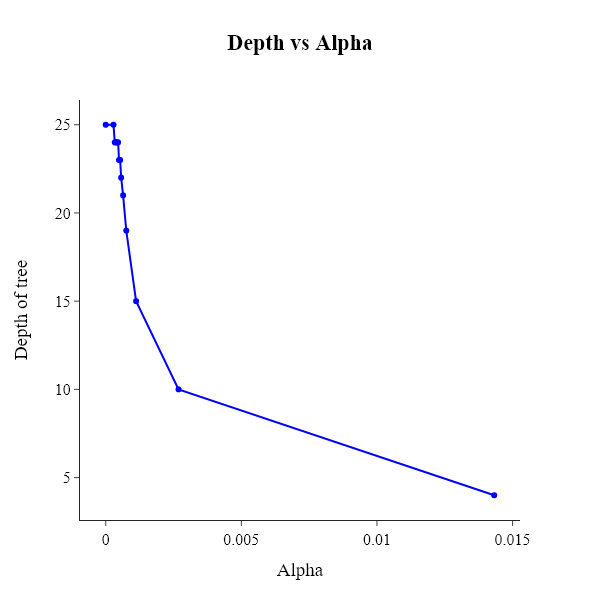

In [20]:
CV.compare_depth_and_alpha(X=X_train, y=y_train)

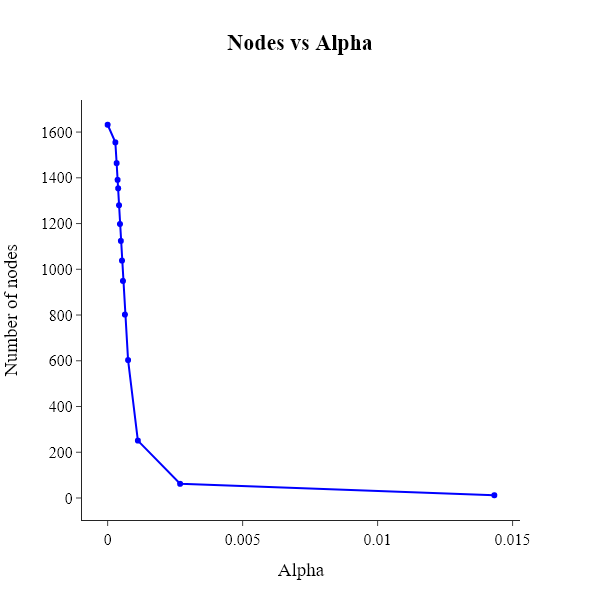

In [21]:
CV.compare_nodes_and_alpha(X=X_train, y=y_train)

$\text{Now let's find out using cross validation what are mean train and valid scores for different values of } ccp\_alpha$

ccp_alpha=0.0: train scores: 1.0; valid scores: 0.91281
ccp_alpha=0.00029: train scores: 1.0; valid scores: 0.91288
ccp_alpha=0.00033: train scores: 1.0; valid scores: 0.91293
ccp_alpha=0.00037: train scores: 1.0; valid scores: 0.91286
ccp_alpha=0.00039: train scores: 1.0; valid scores: 0.91287
ccp_alpha=0.00042: train scores: 1.0; valid scores: 0.91277
ccp_alpha=0.00046: train scores: 0.99998; valid scores: 0.91294
ccp_alpha=0.00049: train scores: 0.99994; valid scores: 0.91302
ccp_alpha=0.00053: train scores: 0.99982; valid scores: 0.91318
ccp_alpha=0.00057: train scores: 0.99957; valid scores: 0.91329
ccp_alpha=0.00064: train scores: 0.99878; valid scores: 0.91352
ccp_alpha=0.00076: train scores: 0.99593; valid scores: 0.91443
ccp_alpha=0.00112: train scores: 0.97395; valid scores: 0.91462
ccp_alpha=0.00268: train scores: 0.91986; valid scores: 0.90701
ccp_alpha=0.01432: train scores: 0.86899; valid scores: 0.8663


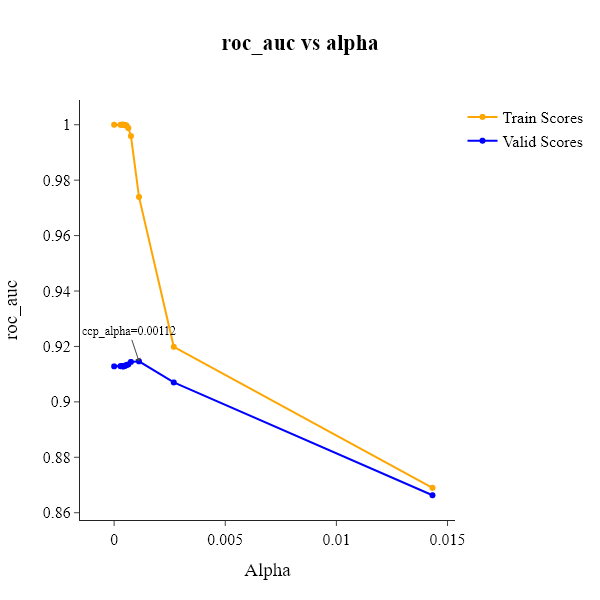

In [22]:
CV.compare_scores_and_alpha(X=X_train, y=y_train, verbose=True)

$\text{We can see that the best value for valid score is obtained for } ccp\_alpha=0.00112$<p>
$\text{Right now we can take a closer look for range: } [0.001, 0.0015]$

ccp_alpha=0.00101: train scores: 0.98232; valid scores: 0.91458
ccp_alpha=0.00101: train scores: 0.98192; valid scores: 0.91455
ccp_alpha=0.00103: train scores: 0.98098; valid scores: 0.91459
ccp_alpha=0.00103: train scores: 0.98075; valid scores: 0.91459
ccp_alpha=0.00103: train scores: 0.98071; valid scores: 0.91456
ccp_alpha=0.00105: train scores: 0.97954; valid scores: 0.91455
ccp_alpha=0.00105: train scores: 0.97948; valid scores: 0.91453
ccp_alpha=0.0011: train scores: 0.97508; valid scores: 0.91465
ccp_alpha=0.00111: train scores: 0.97457; valid scores: 0.91465
ccp_alpha=0.00112: train scores: 0.97369; valid scores: 0.91469
ccp_alpha=0.00117: train scores: 0.97008; valid scores: 0.91471
ccp_alpha=0.00118: train scores: 0.9696; valid scores: 0.9147
ccp_alpha=0.00121: train scores: 0.96716; valid scores: 0.91478
ccp_alpha=0.00122: train scores: 0.96615; valid scores: 0.9147
ccp_alpha=0.00126: train scores: 0.96331; valid scores: 0.91454
ccp_alpha=0.00127: train scores: 0.96254; va

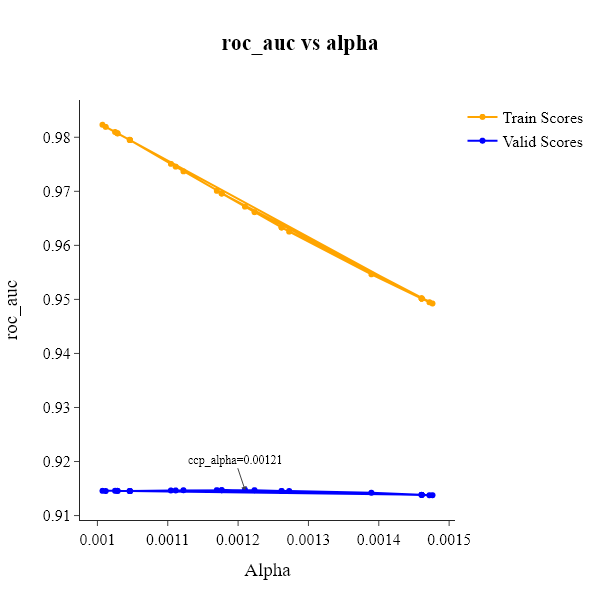

In [23]:
CV.cv_for_range_of_alpha(X=X_train, y=y_train, min_alpha=0.001, max_alpha=0.0015, verbose=True)

$\text{Best valid score was obtained for } ccp\_alpha=0.00121$<p>

<h1>Evaluation and Visualization<h1>

In [24]:
print("Balance accuracy score: {}".format(np.round(balanced_accuracy_score(y_true=y_test, y_pred=base_predictions), 5)))
print("Roc AUC score: {}".format(np.round(roc_auc_score(y_true=y_test, y_score=base_probabilities), 5)))
report = classification_report(y_test, base_predictions, output_dict=True)
df = pd.DataFrame(report).transpose()
print(tabulate(df, headers="keys", tablefmt = 'psql'))

Balance accuracy score: 0.77441
Roc AUC score: 0.77793
+--------------+-------------+----------+------------+------------+
|              |   precision |   recall |   f1-score |    support |
|--------------+-------------+----------+------------+------------|
| 0.0          |    0.775906 | 0.796024 |   0.785836 | 1157       |
| 1.0          |    0.774379 | 0.752788 |   0.763431 | 1076       |
| accuracy     |    0.77519  | 0.77519  |   0.77519  |    0.77519 |
| macro avg    |    0.775142 | 0.774406 |   0.774633 | 2233       |
| weighted avg |    0.77517  | 0.77519  |   0.77504  | 2233       |
+--------------+-------------+----------+------------+------------+


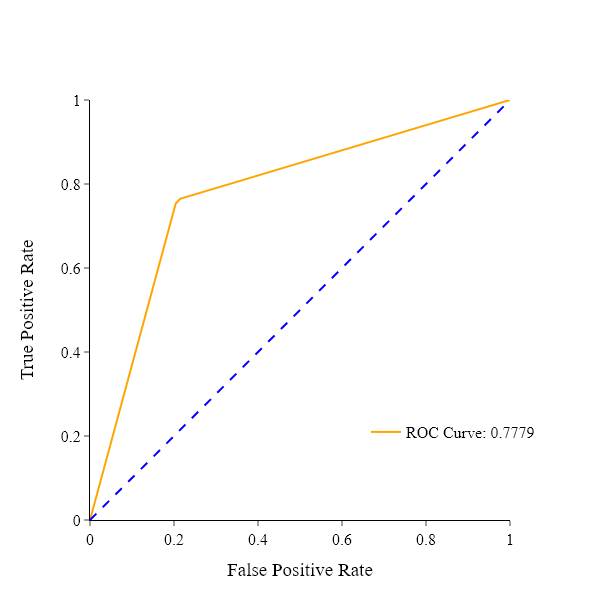

In [25]:
Plots_predictions.roc_auc_plot(y_true=y_test, y_prob=base_probabilities)

$\text{Final estimator pre pruning: } n\_estimators=400, \ bootstrap=True, \ criterion="entropy", \ class\_weight=`balanced`, \ max\_depth=16, \ max\_features=`sqrt`, \ min\_samples\_split=8$

In [26]:
final_algorithm_pre_pruning = RandomForestClassifier(random_state=17, n_jobs=-1, n_estimators=400, bootstrap=True, criterion="entropy", class_weight="balanced", max_depth=16, max_features="sqrt", min_samples_split=8)
final_algorithm_pre_pruning.fit(X_train, np.array(y_train).squeeze())
y_pred_final_pre_pruning = final_algorithm_pre_pruning.predict(X_test)
y_prob_final_pre_pruning = final_algorithm_pre_pruning.predict_proba(X_test)[:, 1]
print("Balance accuracy score: {}".format(np.round(balanced_accuracy_score(y_true=y_test, y_pred=y_pred_final_pre_pruning), 5)))
print("Roc AUC score: {}".format(np.round(roc_auc_score(y_true=y_test, y_score=y_prob_final_pre_pruning), 5)))
report = classification_report(y_test, y_pred_final_pre_pruning, output_dict=True)
df = pd.DataFrame(report).transpose()
print(tabulate(df, headers="keys", tablefmt = 'psql'))

Balance accuracy score: 0.85113
Roc AUC score: 0.9226
+--------------+-------------+----------+------------+-------------+
|              |   precision |   recall |   f1-score |     support |
|--------------+-------------+----------+------------+-------------|
| 0.0          |    0.882682 | 0.81936  |   0.849843 | 1157        |
| 1.0          |    0.819672 | 0.8829   |   0.850112 | 1076        |
| accuracy     |    0.849978 | 0.849978 |   0.849978 |    0.849978 |
| macro avg    |    0.851177 | 0.85113  |   0.849977 | 2233        |
| weighted avg |    0.85232  | 0.849978 |   0.849973 | 2233        |
+--------------+-------------+----------+------------+-------------+


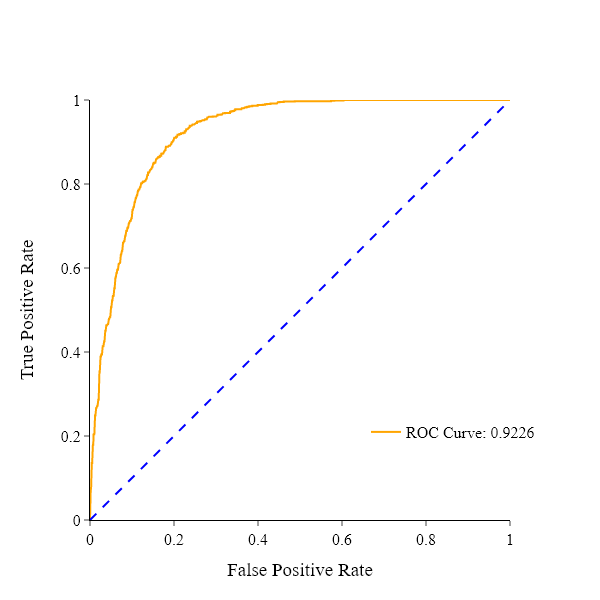

In [27]:
Plots_predictions.roc_auc_plot(y_true=y_test, y_prob=y_prob_final_pre_pruning)

$\text{Final estimator post pruning: } ccp\_alpha=0.00121$

In [28]:
final_algorithm_post_pruning = RandomForestClassifier(ccp_alpha=0.00121, n_estimators=100, criterion="entropy", n_jobs=-1, class_weight=None, bootstrap=True, max_depth=None, max_features=None, min_samples_split=2, random_state=17)
final_algorithm_post_pruning.fit(X_train, np.array(y_train).squeeze())
y_pred_final_post_pruning = final_algorithm_post_pruning.predict(X_test)
y_prob_final_post_pruning = final_algorithm_post_pruning.predict_proba(X_test)[:, 1]
print("Balance accuracy score: {}".format(np.round(balanced_accuracy_score(y_true=y_test, y_pred=y_pred_final_post_pruning), 5)))
print("Roc AUC score: {}".format(np.round(roc_auc_score(y_true=y_test, y_score=y_prob_final_post_pruning), 5)))
report = classification_report(y_test, y_pred_final_post_pruning, output_dict=True)
df = pd.DataFrame(report).transpose()
print(tabulate(df, headers="keys", tablefmt = 'psql'))

Balance accuracy score: 0.85492
Roc AUC score: 0.92153
+--------------+-------------+----------+------------+-------------+
|              |   precision |   recall |   f1-score |     support |
|--------------+-------------+----------+------------+-------------|
| 0.0          |    0.881543 | 0.829732 |   0.854853 | 1157        |
| 1.0          |    0.827797 | 0.880112 |   0.853153 | 1076        |
| accuracy     |    0.854008 | 0.854008 |   0.854008 |    0.854008 |
| macro avg    |    0.85467  | 0.854922 |   0.854003 | 2233        |
| weighted avg |    0.855645 | 0.854008 |   0.854034 | 2233        |
+--------------+-------------+----------+------------+-------------+


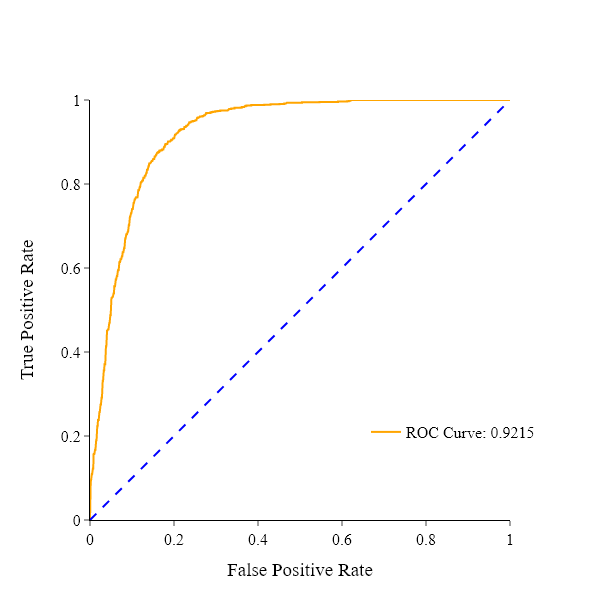

In [29]:
Plots_predictions.roc_auc_plot(y_true=y_test, y_prob=y_prob_final_post_pruning)

$\text{As we can see hyperparameter tuning for both pre and post pruning have significantly improved the effectiveness of the Random Forest!}$

<h2>Regression forest<h2>

$\text{Again, all information about how single Decision Tree is bulit here: }$ [Decision Tree Example](https://github.com/kvbiii/ML_Algorithms_from_scratch/blob/main/Decision_Tree/Decision_Tree_example.ipynb)<p>

<h1>Preprocessing<h1>

<h2>Download data<h2>

In [30]:
data = pd.read_csv("Data/Sales.csv")
X = data.drop("Sales", axis=1)
y = data["Sales"]

In [31]:
print("Number of observations in data: {}".format(len(data)))
data.head()

Number of observations in data: 4572


,TV,Radio,Social Media,Influencer,Sales
0,16.0,6.566231,2.907983,Mega,54.732757
1,13.0,9.237765,2.409567,Mega,46.677897
2,41.0,15.886446,2.913410,Mega,150.177829
3,83.0,30.020028,6.922304,Mega,298.246340
4,15.0,8.437408,1.405998,Micro,56.594181


<h2>Check for null data<h2>

In [32]:
data.isnull().sum()/len(data)

TV              0.002187
Radio           0.000875
Social Media    0.001312
Influencer      0.000000
Sales           0.001312
dtype: float64

In [33]:
data.dropna(inplace=True)

<h2>Convert object to numeric<h2>

In [34]:
list_of_object_features = data.select_dtypes(include="object").columns.tolist()
list_of_numeric_features = data.select_dtypes(exclude="object").columns.tolist()
encoder = OrdinalEncoder()
data[list_of_object_features] = encoder.fit_transform(data[list_of_object_features])

<h2>Divide our data into train and test sets<h2>

In [35]:
target_binary = "Sales"
X = data.drop(target_binary, axis=1)
y = data[[target_binary]]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=17, test_size=0.2)

<h1>Evaluation and Visualization<h1>

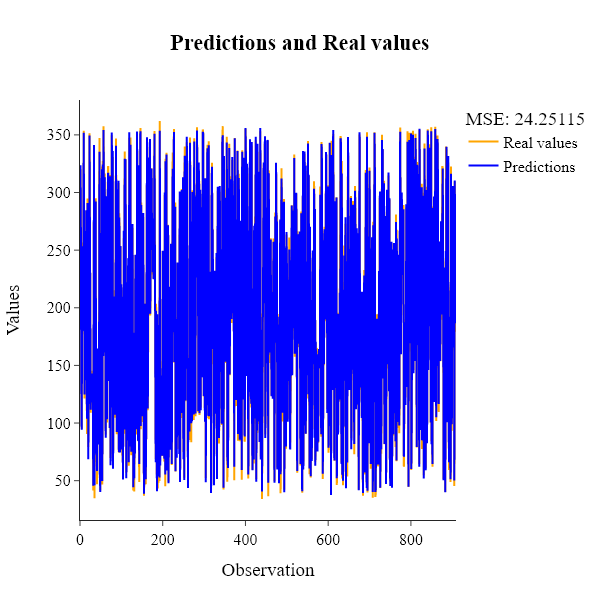

In [36]:
model = Random_Forest_Regressor(n_estimators=10, bootstrap=True, criterion="squared_error", max_depth=None, max_features="sqrt", min_samples_split=2, random_state=17)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
Plots_predictions.compare_predictions_with_real_values(y_true=y_test, y_pred=y_pred, metric="MSE")

<h2>Features importance<h2>

$\text{The features importance for a random forest is determined in the same way as for decision trees, but in this case the number of trees in the forest must also be taken into account:}$

$$feature\_importnace_m=\frac{\sum_{t\in n u m b e r\ of\ trees}{feature\_importnace}_{m,t}}{number\ of\ trees}$$

$\text{Where: number of trees - the number of all trees in the forest,}$<p>
${feature\_importnace}_{m,t} \text{ - the importance of variable } m \text{ for tree } t.$

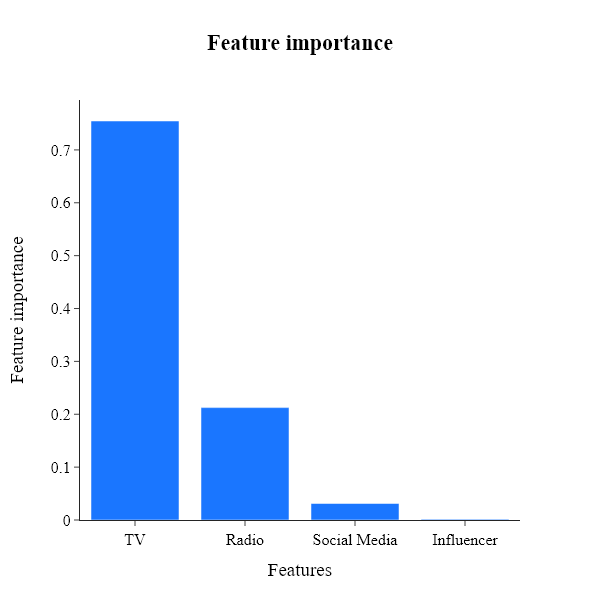

In [37]:
Plots_predictions.plot_feature_importances(feature_importances=list(model.normalized_feature_importances.values()), column_names=X.columns.tolist())

<h1>Advantages and disadvantages of Random Forest<h1>

$\text{Advantages of Random Forest:}$<p>
$\text{- Solves the problem of overfitting found in decision trees, by averaging the results/majority voting,}$<p>
$\text{- Including different data sets } (bootstrap, \ max\_features) \text{ in each forest tree helps reduce error variance.}$<br>

$\text{Disadvantages of Random Forest:}$<p>
$\text{- Much more difficult to interpret the results obtained than in the case of decision trees (due to the large number of trees and the differences in input data between them),}$<p>
$\text{- Higher complexity than decision trees, contributes to longer compilation time.}$